In [2]:
# Import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

# Import metrics from sklearn
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                              f1_score, confusion_matrix, classification_report)
from sklearn.model_selection import train_test_split

In [22]:
# DataLoader
def load_data_with_validation_split(train_path, test_path, batch_size=32, 
                                      val_split=0.2, img_size=224, num_workers=2):
    # Define transforms
    train_transform = transforms.Compose([
        #transforms.Resize((img_size, img_size)),
        transforms.RandomResizedCrop(
        img_size,  # Output size (224)
        scale=(0.8, 1.0),  # Randomly scale between 80% and 100% of original
        ratio=(0.9, 1.1)   # Aspect ratio range
    ),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])

    test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # Load full training dataset w/o augmentation first
    base_trainset = ImageFolder(root=train_path)

    # Split training directiory into train and validation sets
    train_size = int((1 - val_split) * len(base_trainset))
    val_size = len(base_trainset) - train_size
    
    # split to get indices for train and val with the actual transforms applied later
    train_set, val_set = random_split(base_trainset, [train_size, val_size],
                                     generator=torch.Generator().manual_seed(42))
    
    # New ImageFolder datasets for train and val with transforms
    train_data = ImageFolder(root=train_path, transform=train_transform)
    val_data = ImageFolder(root=train_path, transform=test_transform)

    # Create subsets using the indices from the split

    trainset = Subset(train_data, train_set.indices)
    valset = Subset(val_data, val_set.indices)

    # Load test dataset
    testset = ImageFolder(root=test_path, transform=test_transform)

    # Create dataloaders
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    classes = base_trainset.classes

    print(f'Classes: {classes}')
    print(f'Training samples: {len(trainset)}')
    print(f'Validation samples: {len(valset)}')
    print(f'Testing samples: {len(testset)}')
    
    return trainloader, valloader, testloader, classes

# Load data with train/val split
train_path = '/Users/jasonzhao/Documents/ECS CLASSES/ecs174/mridataset/Training'
test_path = '/Users/jasonzhao/Documents/ECS CLASSES/ecs174/mridataset/Testing'

trainloader, valloader, testloader, classes = load_data_with_validation_split(
    train_path, test_path, batch_size=32, val_split=0.2
)


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Training samples: 4569
Validation samples: 1143
Testing samples: 1311


In [24]:
#Model
class Net(nn.Module):
    """
    Simple CNN architecture similar to PyTorch tutorial.
    """
    def __init__(self, num_classes=4):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 6, 5)  # 3 input channels (RGB), 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2)   # 2x2 pooling
        self.conv2 = nn.Conv2d(6, 16, 5)  # 6 input channels, 16 output channels, 5x5 kernel
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Flatten
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net(num_classes=4)


In [ ]:
# Evaluation Functions
def calculate_specificity(y_true, y_pred, num_classes):
    cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
    specificities = []
    
    for i in range(num_classes):
        # True Negatives: sum of all cells except row i and column i
        tn = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
        # False Positives: sum of column i except diagonal
        fp = np.sum(cm[:, i]) - cm[i, i]
        
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificities.append(specificity)
    
    return specificities

def evaluate_model(model, dataloader, classes, dataset_name="Test"):
  
    model.eval()
    
    all_preds = []
    all_labels = []
    
    # Collect all predictions and labels
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0], data[1]
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    
    # Per-class metrics
    precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
    f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)
    specificity = calculate_specificity(all_labels, all_preds, len(classes))
    
    # Average metrics
    precision_avg = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall_avg = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1_avg = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    specificity_avg = np.mean(specificity)
    
    # Print results
    print(f"\n{'='*70}")
    print(f"{dataset_name} Set Evaluation")
    print(f"{'='*70}")
    print(f"Overall Accuracy: {accuracy*100:.2f}%\n")
    
    print(f"{'Class':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Specificity':<10}")
    print(f"{'-'*70}")
    
    # Calculate per-class accuracy
    for i, class_name in enumerate(classes):
        class_mask = all_labels == i
        class_accuracy = np.sum((all_preds == all_labels) & class_mask) / np.sum(class_mask) if np.sum(class_mask) > 0 else 0
        
        print(f"{class_name:<15} {class_accuracy*100:>8.2f}% {precision[i]*100:>9.2f}% "
              f"{recall[i]*100:>9.2f}% {f1[i]*100:>9.2f}% {specificity[i]*100:>9.2f}%")
    
    print(f"{'-'*70}")
    print(f"{'Weighted Avg':<15} {accuracy*100:>8.2f}% {precision_avg*100:>9.2f}% "
          f"{recall_avg*100:>9.2f}% {f1_avg*100:>9.2f}% {specificity_avg*100:>9.2f}%")
    print(f"{'='*70}\n")
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(f"{'':>15}", end='')
    for class_name in classes:
        print(f"{class_name:<15}", end='')
    print()
    for i, class_name in enumerate(classes):
        print(f"{class_name:>15}", end='')
        for j in range(len(classes)):
            print(f"{cm[i, j]:<15}", end='')
        print()
    print()
    
    # Store metrics in dictionary
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'specificity': specificity,
        'precision_avg': precision_avg,
        'recall_avg': recall_avg,
        'f1_avg': f1_avg,
        'specificity_avg': specificity_avg,
        'confusion_matrix': cm
    }
    
    return metrics


In [ ]:
# Training Phase

def train_model(model, trainloader, valloader, classes, 
                num_epochs=5, lr=0.001, momentum=0.9, save_path='./brain_tumor_cnn.pth'):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0], data[1]
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            
        
        # Calculate training accuracy
        train_acc = 100 * train_correct / train_total
        train_loss = running_loss / len(trainloader)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data in valloader:
                images, labels = data[0], data[1]
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = 100 * val_correct / val_total
        val_loss = val_loss / len(valloader)
        
        # append all loss and accuracies
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        
        # Print epoch summary
        print(f'\nEpoch {epoch + 1}/{num_epochs}:')
        print(f'  Training    Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%')
        print(f'  Validation  Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%')
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)
            print(f'Best model saved! (Val Acc: {val_acc:.2f}%)')
        print()
    
    print('Finished Training')
    print(f'Best Validation Accuracy: {best_val_acc:.2f}%')
    print(f'Model saved to {save_path}')
    
    return history

def plot_training_history(history):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot accuracy
    ax1.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    ax1.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy (%)', fontsize=12)
    ax1.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Plot loss
    ax2.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    ax2.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Train the model
print("Starting training...")
history = train_model(net, trainloader, valloader, classes, 
                      num_epochs=50, lr=0.001, momentum=0.9)


Starting training...

Epoch 1/50:
  Training    Loss: 1.2839, Accuracy: 39.31%
  Validation  Loss: 0.9923, Accuracy: 58.62%
Best model saved! (Val Acc: 58.62%)


Epoch 2/50:
  Training    Loss: 0.9749, Accuracy: 59.49%
  Validation  Loss: 0.7989, Accuracy: 68.68%
Best model saved! (Val Acc: 68.68%)


Epoch 3/50:
  Training    Loss: 0.8451, Accuracy: 64.59%
  Validation  Loss: 0.6688, Accuracy: 74.10%
Best model saved! (Val Acc: 74.10%)


Epoch 4/50:
  Training    Loss: 0.7895, Accuracy: 67.83%
  Validation  Loss: 0.6790, Accuracy: 75.15%
Best model saved! (Val Acc: 75.15%)


Epoch 5/50:
  Training    Loss: 0.7123, Accuracy: 70.98%
  Validation  Loss: 0.5990, Accuracy: 75.59%
Best model saved! (Val Acc: 75.59%)


Epoch 6/50:
  Training    Loss: 0.6557, Accuracy: 73.93%
  Validation  Loss: 0.6185, Accuracy: 73.75%


Epoch 7/50:
  Training    Loss: 0.6132, Accuracy: 75.36%
  Validation  Loss: 0.5005, Accuracy: 81.89%
Best model saved! (Val Acc: 81.89%)


Epoch 8/50:
  Training    Loss: 0.

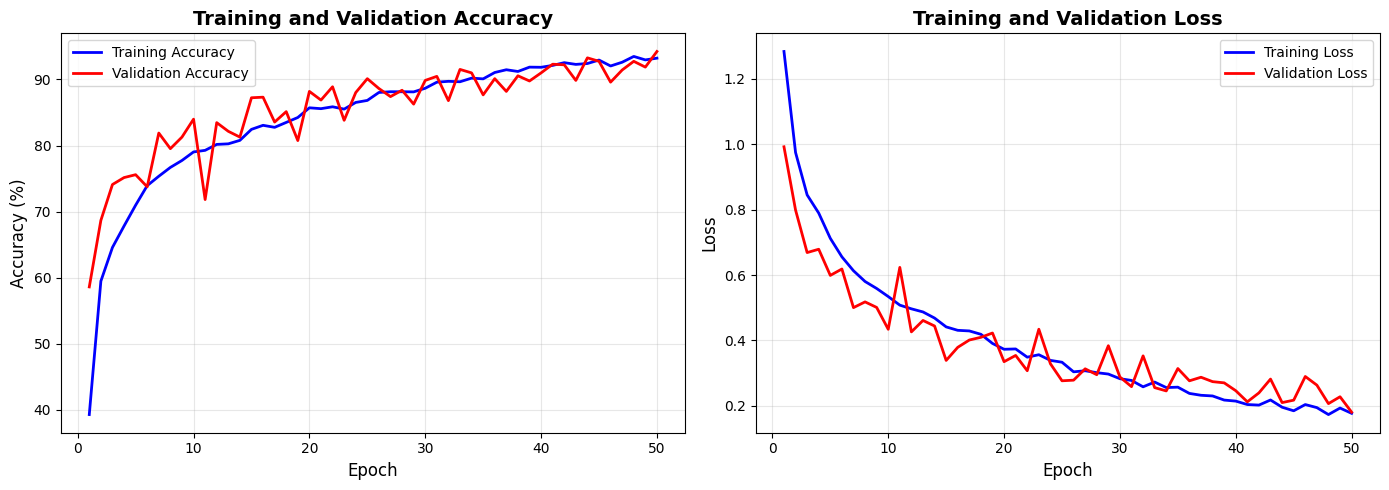

In [26]:
# Plot training history
plot_training_history(history)


In [ ]:
# Evaluate on validation set
val_metrics = evaluate_model(net, valloader, classes, dataset_name="Validation")



Validation Set Evaluation
Overall Accuracy: 78.64%

Class           Accuracy   Precision  Recall     F1-Score   Specificity
----------------------------------------------------------------------
glioma             82.67%     72.09%     82.67%     77.02%     90.50%
meningioma         36.27%     87.40%     36.27%     51.27%     98.41%
notumor            93.33%     85.52%     93.33%     89.26%     92.94%
pituitary          98.00%     73.87%     98.00%     84.24%     89.71%
----------------------------------------------------------------------
Weighted Avg       78.64%     80.22%     78.64%     76.44%     92.89%

Confusion Matrix:
               glioma         meningioma     notumor        pituitary      
         glioma248            14             0              38             
     meningioma81             111            64             50             
        notumor10             1              378            16             
      pituitary5              1              0              

In [27]:
# Evaluate on test set (unseen data)
test_metrics = evaluate_model(net, testloader,classes, dataset_name="Test")



Test Set Evaluation
Overall Accuracy: 93.44%

Class           Accuracy   Precision  Recall     F1-Score   Specificity
----------------------------------------------------------------------
glioma             86.00%     94.16%     86.00%     89.90%     98.42%
meningioma         93.79%     83.92%     93.79%     88.58%     94.53%
notumor            98.52%     98.28%     98.52%     98.40%     99.23%
pituitary          93.67%     97.23%     93.67%     95.42%     99.21%
----------------------------------------------------------------------
Weighted Avg       93.44%     93.74%     93.44%     93.48%     97.85%

Confusion Matrix:
               glioma         meningioma     notumor        pituitary      
         glioma258            40             2              0              
     meningioma7              287            5              7              
        notumor3              2              399            1              
      pituitary6              13             0              281   